In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from xgboost import XGBRegressor

import copy
import time

## Obróbka danych


In [2]:
# upload data
test_data = pd.read_excel('test.xlsx')
test_data.head(5)

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory
0,The Complete Sherlock Holmes: 2 Boxes sets,Sir Arthur Conan Doyle,"Mass Market Paperback,– 1 Oct 1986",4.4 out of 5 stars,960 customer reviews,A collection of entire body of work of the She...,Short Stories (Books),"Crime, Thriller & Mystery"
1,Learn Docker - Fundamentals of Docker 18.x: Ev...,Gabriel N. Schenker,"Paperback,– Import, 26 Apr 2018",5.0 out of 5 stars,1 customer review,Enhance your software deployment workflow usin...,Operating Systems Textbooks,"Computing, Internet & Digital Media"
2,Big Girl,Danielle Steel,"Paperback,– 17 Mar 2011",5.0 out of 5 stars,4 customer reviews,"'Watch out, world. Here I come!'\nFor Victoria...",Romance (Books),Romance
3,Think Python: How to Think Like a Computer Sci...,Allen B. Downey,"Paperback,– 2016",4.1 out of 5 stars,11 customer reviews,"If you want to learn how to program, working w...",Programming & Software Development (Books),"Computing, Internet & Digital Media"
4,Oxford Word Skills: Advanced - Idioms & Phrasa...,Redman Gairns,"Paperback,– 26 Dec 2011",4.4 out of 5 stars,9 customer reviews,"Learn and practise the verbs, prepositions and...",Linguistics (Books),"Language, Linguistics & Writing"


In [3]:
train_data = pd.read_excel('train.xlsx')
train_data.head(5)

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6237 entries, 0 to 6236
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         6237 non-null   object 
 1   Author        6237 non-null   object 
 2   Edition       6237 non-null   object 
 3   Reviews       6237 non-null   object 
 4   Ratings       6237 non-null   object 
 5   Synopsis      6237 non-null   object 
 6   Genre         6237 non-null   object 
 7   BookCategory  6237 non-null   object 
 8   Price         6237 non-null   float64
dtypes: float64(1), object(8)
memory usage: 438.7+ KB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         1560 non-null   object
 1   Author        1560 non-null   object
 2   Edition       1560 non-null   object
 3   Reviews       1560 non-null   object
 4   Ratings       1560 non-null   object
 5   Synopsis      1560 non-null   object
 6   Genre         1560 non-null   object
 7   BookCategory  1560 non-null   object
dtypes: object(8)
memory usage: 97.6+ KB


In [6]:
train_data.describe()

,Price
count,6237.000000
mean,560.707516
std,690.110657
min,25.000000
25%,249.180000
50%,373.000000
75%,599.000000
max,14100.000000


In [7]:
train_data.describe(include='all').head(2)

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
count,6237,6237,6237,6237,6237,6237,6237,6237,6237.0
unique,5568,3679,3370,36,342,5549,345,11,NaN


In [8]:
train_data['Type'] = 'train'
test_data['Type'] = 'test'

data = pd.concat([train_data, test_data])
data.columns = data.columns.str.strip()

# usunięcie kolumny Synopsis
data = data.drop(['Synopsis', 'Title', 'Author'], axis=1)

# obróbka Reviews i Ratings na liczby
data['Reviews'] = data['Reviews'].apply(lambda x: x.split()[0]).astype('float')
data['Ratings'] = data['Ratings'].apply(lambda x: int(x.split()[0].replace(',', '')))

# rozkład Edition na skłądowe kolumny
data['Year'] = data['Edition'].apply(lambda x : x.split()[-1])
data['Year'] = data['Year'].apply(lambda x : x if x.isdigit() else np.nan)

data['Edition'] = data['Edition'].apply(lambda x : x.split(',')[1] if x.startswith('(') else x.split(',')[0])
data.head()

,Edition,Reviews,Ratings,Genre,BookCategory,Price,Type,Year
0,Paperback,4.0,8,Action & Adventure (Books),Action & Adventure,220.00,train,2016
1,Paperback,3.9,14,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,train,2012
2,Paperback,4.8,6,International Relations,Humour,299.00,train,1982
3,Paperback,4.1,13,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,train,2017
4,Hardcover,5.0,1,Photography Textbooks,"Arts, Film & Photography",965.62,train,2006


In [9]:
# Sprawdzenie wartości brakujących
data.Year.isna().sum()

30

In [10]:
# uzupełnienie brakujących danych
data['Year'] = data['Year'].fillna(data['Year'].mode().iloc[0]).astype(np.int16)
data.Year.isna().sum()

0

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7797 entries, 0 to 1559
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Edition       7797 non-null   object 
 1   Reviews       7797 non-null   float64
 2   Ratings       7797 non-null   int64  
 3   Genre         7797 non-null   object 
 4   BookCategory  7797 non-null   object 
 5   Price         6237 non-null   float64
 6   Type          7797 non-null   object 
 7   Year          7797 non-null   int16  
dtypes: float64(2), int16(1), int64(1), object(4)
memory usage: 502.5+ KB


In [12]:
data.describe()

,Reviews,Ratings,Price,Year
count,7797.000000,7797.000000,6237.000000,7797.000000
mean,4.295845,35.520841,560.707516,2011.916891
std,0.663513,153.020897,690.110657,7.831064
min,1.000000,1.000000,25.000000,1900.000000
25%,4.000000,2.000000,249.180000,2010.000000
50%,4.400000,6.000000,373.000000,2015.000000
75%,4.800000,21.000000,599.000000,2017.000000
max,5.000000,6090.000000,14100.000000,2019.000000


In [13]:
data.describe(include='all').head(2)

,Edition,Reviews,Ratings,Genre,BookCategory,Price,Type,Year
count,7797,7797.0,7797.0,7797,7797,6237.0,7797,7797.0
unique,15,NaN,NaN,363,11,NaN,2,NaN


In [14]:
data['Edition'].value_counts()

Paperback                6463
Hardcover                1056
Mass Market Paperback     200
Sheet music                32
Flexibound                 19
Cards                       9
Spiral-bound                6
Loose Leaf                  3
Tankobon Softcover          3
Plastic Comb                1
Perfect Paperback           1
Board book                  1
Product Bundle              1
Library Binding             1
Leather Bound               1
Name: Edition, dtype: int64

In [15]:
# kategoryzowanie
data['Edition'] = data['Edition'].apply(lambda x : x if x in ['Paperback','Hardcover','Mass Market Paperback','Sheet music','Flexibound'] else 'Others')
print(data['Edition'].value_counts())

Paperback                6463
Hardcover                1056
Mass Market Paperback     200
Sheet music                32
Others                     27
Flexibound                 19
Name: Edition, dtype: int64


In [16]:
data.head()

,Edition,Reviews,Ratings,Genre,BookCategory,Price,Type,Year
0,Paperback,4.0,8,Action & Adventure (Books),Action & Adventure,220.00,train,2016
1,Paperback,3.9,14,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,train,2012
2,Paperback,4.8,6,International Relations,Humour,299.00,train,1982
3,Paperback,4.1,13,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,train,2017
4,Hardcover,5.0,1,Photography Textbooks,"Arts, Film & Photography",965.62,train,2006


C:\Users\Admin\AppData\Local\Temp/ipykernel_15936/1679999493.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot = True)


<AxesSubplot:>

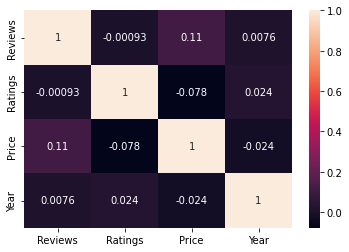

In [17]:
sns.heatmap(data.corr(), annot = True)

In [18]:
data['Genre'].value_counts()

Action & Adventure (Books)               1183
Romance (Books)                           517
Biographies & Autobiographies (Books)     463
Crime, Thriller & Mystery (Books)         335
Contemporary Fiction (Books)              325
                                         ... 
Bodybuilding & Weightlifting (Books)        1
Immunology                                  1
Target Shooting (Books)                     1
Ecotourism                                  1
Military History (Books)                    1
Name: Genre, Length: 363, dtype: int64

In [19]:
data['BookCategory'].value_counts()

Action & Adventure                      1036
Crime, Thriller & Mystery                878
Comics & Mangas                          744
Language, Linguistics & Writing          733
Biographies, Diaries & True Accounts     732
Romance                                  702
Humour                                   670
Computing, Internet & Digital Media      648
Arts, Film & Photography                 638
Sports                                   614
Politics                                 402
Name: BookCategory, dtype: int64

In [20]:
data = data.drop(["Genre"], axis=1)
data.head()

,Edition,Reviews,Ratings,BookCategory,Price,Type,Year
0,Paperback,4.0,8,Action & Adventure,220.00,train,2016
1,Paperback,3.9,14,"Biographies, Diaries & True Accounts",202.93,train,2012
2,Paperback,4.8,6,Humour,299.00,train,1982
3,Paperback,4.1,13,"Crime, Thriller & Mystery",180.00,train,2017
4,Hardcover,5.0,1,"Arts, Film & Photography",965.62,train,2006


In [21]:
# podział na zbiory testowy i treningowy
train = data[data["Type"] == 'train']
test = data[data["Type"] == 'test']

train = train.drop(['Type'], axis=1)
test = test.drop(['Type'], axis=1)

train.head()

,Edition,Reviews,Ratings,BookCategory,Price,Year
0,Paperback,4.0,8,Action & Adventure,220.00,2016
1,Paperback,3.9,14,"Biographies, Diaries & True Accounts",202.93,2012
2,Paperback,4.8,6,Humour,299.00,1982
3,Paperback,4.1,13,"Crime, Thriller & Mystery",180.00,2017
4,Hardcover,5.0,1,"Arts, Film & Photography",965.62,2006


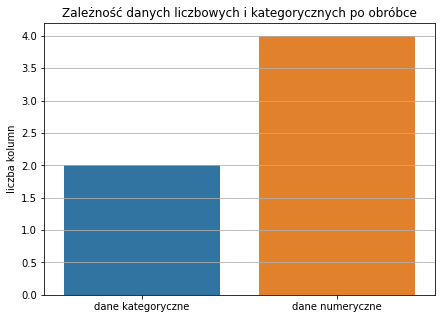

In [22]:
col_data_type = []
for col in train.columns:
    if pd.api.types.is_numeric_dtype(train[col]):
        col_data_type.append('dane numeryczne')
    else:
        col_data_type.append('dane kategoryczne')


plt.figure(figsize=(7,5))
plt.grid()
sns.countplot(x=col_data_type)
plt.ylabel('liczba kolumn')
plt.title('Zależność danych liczbowych i kategorycznych po obróbce')
plt.show()

## Kodowanie i skalowanie danych

In [23]:
encode = LabelEncoder()
new_data = copy.copy(data)
new_data['Edition'] = encode.fit_transform(list(data['Edition']))
new_data['BookCategory'] = encode.fit_transform(list(data['BookCategory']))
new_data['Year'] = encode.fit_transform(list(data['Year']))
new_data.head()

,Edition,Reviews,Ratings,BookCategory,Price,Type,Year
0,4,4.0,8,0,220.00,train,54
1,4,3.9,14,2,202.93,train,50
2,4,4.8,6,6,299.00,train,20
3,4,4.1,13,5,180.00,train,55
4,1,5.0,1,1,965.62,train,44


In [24]:
# podział na zbiory testowy i treningowy
new_train = new_data[new_data["Type"] == 'train']
new_test = new_data[new_data["Type"] == 'test']

new_train = new_train.drop(['Type'], axis=1)
new_test = new_test.drop(['Type'], axis=1)

new_train.head()

,Edition,Reviews,Ratings,BookCategory,Price,Year
0,4,4.0,8,0,220.00,54
1,4,3.9,14,2,202.93,50
2,4,4.8,6,6,299.00,20
3,4,4.1,13,5,180.00,55
4,1,5.0,1,1,965.62,44


In [25]:
X_train = new_train.drop(['Price'],axis = 1)
y_train = new_train['Price'].values
X_test = new_test.drop(["Price"], axis=1)

# SCALE
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# reshaping
y_train = y_train.reshape((len(y_train), 1))
y_train = sc.fit_transform(y_train)
y_train = y_train.ravel()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(X_train)

(6237, 5)
(1560, 5)
(6237,)
[[ 0.42881945 -0.44260333 -0.18658305 -1.46017334  0.53345711]
 [ 0.42881945 -0.59355848 -0.14657852 -0.82907247  0.00957552]
 [ 0.42881945  0.76503793 -0.1999179   0.43312927 -3.91953646]
 ...
 [ 0.42881945 -0.74451364 -0.21992016  1.37978058 -0.77624688]
 [ 0.42881945 -1.19737911 -0.21325274 -1.46017334  0.40248671]
 [ 0.42881945 -0.59355848 -0.22658759 -1.46017334  0.53345711]]


## XGBoost

(4178, 5)
(4178,)
(2059, 5)
(2059,)
Training score 0.8963776302828373
Mean absolute percentage error 0.985649565036682


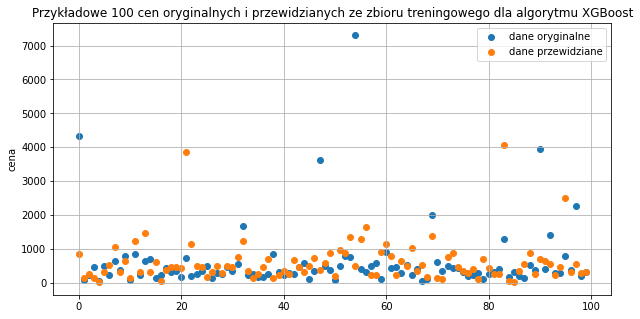

In [34]:
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size = 0.33, random_state = 123)

print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)

xgb=XGBRegressor(n_estimators=2000, max_depth=7, learning_rate = 0.1)

xgb.fit(train_x, train_y)

y_ = xgb.predict(val_x)

y_pred = sc.inverse_transform([y_])
y_true = sc.inverse_transform([val_y])

score_ = xgb.score(train_x, train_y)
score_perc = mean_absolute_percentage_error(y_pred, y_true)
print("Training score", score_)
print("Mean absolute percentage error", score_perc)

x_ax = range(len(y_true[0][:100]))

plt.figure(figsize=(10,5))
plt.scatter(x_ax, y_true[0][:100], label="dane oryginalne")
plt.scatter(x_ax, y_pred[0][:100], label="dane przewidziane")
plt.title("Przykładowe 100 cen oryginalnych i przewidzianych ze zbioru treningowego dla algorytmu XGBoost")
plt.ylabel('cena')
plt.grid()
plt.legend()
plt.show()

In [26]:
def xgb_model(X_train, y_train, X_test, n, m, l):
    """"
    Returns score of fitted XGBoost model for varius parameters.

        Parameters:
                X_train (numpy.ndarray): Training set X
                y_train (numpy.ndarray): Training set y
                X_test (numpy.ndarray): Testing set to predict values for
                n (int): number of model estimators
                m (int): value of model depth
                l (float): value of model learning rate
        Returns:
                score (float): training score of the model
    """
    xgb=XGBRegressor(n_estimators=n, max_depth=m, learning_rate=l)

    xgb.fit(X_train, y_train)

    y_ = xgb.predict(X_test)

    return xgb.score(X_train, y_train)

In [27]:
def vizualization(x_lim, y_lim, y_time, title1, title2, title3, x_label):
    """
    Responsible for visualization of score and time run of tested algorithms.
    Returns three plots: score, time and both on the same plot.

        Parameters:
                x_lim (numpy.ndarray): set of x values for plot
                y_lim (numpy.ndarray): set of y values for plot - score
                y_time (numpy.ndarray): array containing time samples
                title1 (string): string containing title for first plot
                title2 (string): string containing title for second plot
                title3 (string): string containing title for third plot
                x_label (string): string containing label for axis x
    """

    plt.figure()
    plt.plot(x_lim, y_lim, '-o', color='orange')
    plt.title(title1)
    plt.grid()
    plt.ylabel('jakość')
    plt.xlabel(x_label)
    plt.show()

    plt.figure()
    plt.plot(x_lim, y_time, '-o')
    plt.title(title2)
    plt.grid()
    plt.ylabel('czas [s]')
    plt.xlabel(x_label)
    plt.show()

    fig, ax1 = plt.subplots()
    ax1.plot(x_lim, y_lim, color='orange', marker='o')
    ax1.grid()
    ax1.set_title(title3)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel('jakosć', color='orange')

    ax2=ax1.twinx()
    ax2.plot(x_lim, y_time, color='blue', marker='o')
    ax2.set_ylabel("czas [s] ", color='blue')
    plt.show()

Training score:  0.5039427526567345
Training score:  0.628494562168564
Training score:  0.6901216418043856
Training score:  0.7231995973339544
Training score:  0.7491667685878274
Training score:  0.7692289303170099
Training score:  0.7840635605028036
Training score:  0.7951775246339129
Training score:  0.8034068688392966
Training score:  0.8106279748756485
Training score:  0.8156406832184091
Training score:  0.8210125026560494


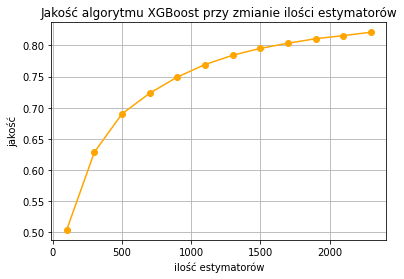

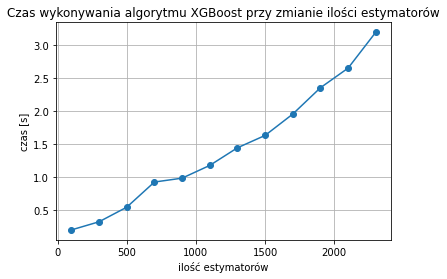

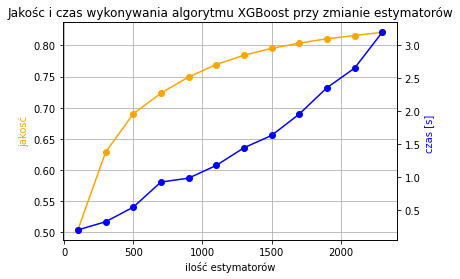

In [28]:
N = np.arange(100, 2500, 200)
skorr = []
times = []
for n in N:
    start = time.time()
    score_ = xgb_model(X_train=X_train, y_train=y_train, X_test=X_test, n=n, m=6, l=0.1)
    stop = time.time()

    print("Training score: ", score_)
    skorr.append(score_)
    times.append(stop-start)

vizualization(
    x_lim = N,
    y_lim = skorr,
    y_time = times,
    title1 = 'Jakość algorytmu XGBoost przy zmianie ilości estymatorów',
    title2 = 'Czas wykonywania algorytmu XGBoost przy zmianie ilości estymatorów',
    title3 = 'Jakośc i czas wykonywania algorytmu XGBoost przy zmianie estymatorów',
    x_label = 'ilość estymatorów'
)

Training score:  0.185421452245637
Training score:  0.2876261231310321
Training score:  0.46221208328806607
Training score:  0.611414001786333
Training score:  0.7359415232285741
Training score:  0.8156406832184091
Training score:  0.8477357776324338
Training score:  0.8534618009858026
Training score:  0.8536844813664793
Training score:  0.8537322510001268
Training score:  0.853788958808836
Training score:  0.8537818290744411
Training score:  0.8538374841038239
Training score:  0.8538428038590009


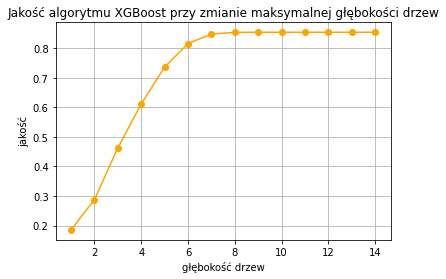

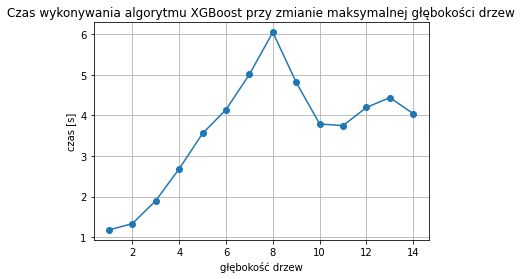

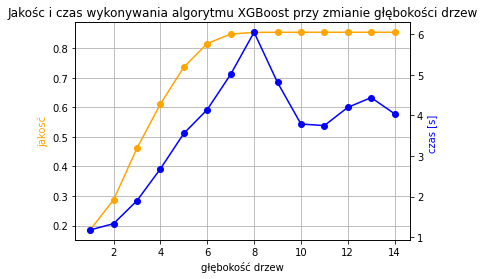

In [35]:
skorr = []
times = []

D = np.arange(1, 15)
for d in D:
    start = time.time()
    score_ = xgb_model(X_train=X_train, y_train=y_train, X_test=X_test, n=2100, m=d, l=0.1)
    stop = time.time()

    print("Training score: ", score_)
    skorr.append(score_)
    times.append(stop-start)

vizualization(
    x_lim = D,
    y_lim = skorr,
    y_time = times,
    title1 = 'Jakość algorytmu XGBoost przy zmianie maksymalnej głębokości drzew',
    title2 = 'Czas wykonywania algorytmu XGBoost przy zmianie maksymalnej głębokości drzew',
    title3 = 'Jakośc i czas wykonywania algorytmu XGBoost przy zmianie głębokości drzew',
    x_label = 'głębokość drzew'
)

Training score:  0.8534618009858026
Training score:  0.8536894427854244
Training score:  0.853754884940201
Training score:  0.8538047823941899
Training score:  0.8538241091945435
Training score:  0.8538383808139985
Training score:  0.8538506912301173
Training score:  0.8538530804776934
Training score:  0.8538559760390811
Training score:  0.8538666176732177


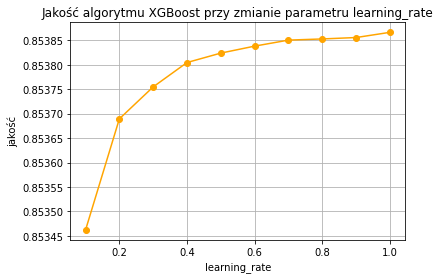

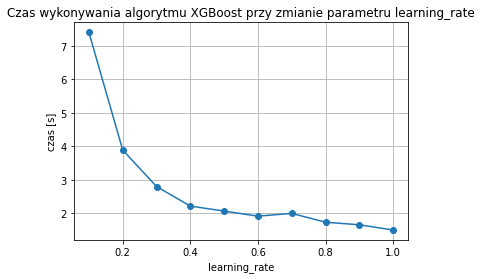

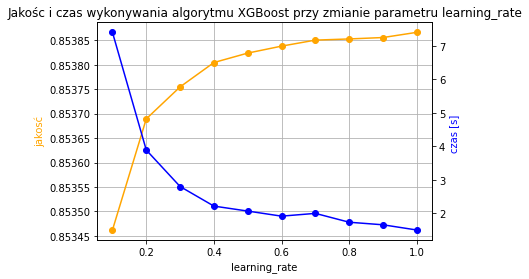

In [36]:
skorr = []
times = []

I = np.arange(0.1, 1.1, 0.1)
for i in I:
    start = time.time()
    score_ = xgb_model(X_train=X_train, y_train=y_train, X_test=X_test, n=2100, m=8, l=i)
    stop = time.time()

    print("Training score: ", score_)
    skorr.append(score_)
    times.append(stop-start)

vizualization(
    x_lim = I,
    y_lim = skorr,
    y_time = times,
    title1 = 'Jakość algorytmu XGBoost przy zmianie parametru learning_rate',
    title2 = 'Czas wykonywania algorytmu XGBoost przy zmianie parametru learning_rate',
    title3 = 'Jakośc i czas wykonywania algorytmu XGBoost przy zmianie parametru learning_rate',
    x_label = 'learning_rate'
)

In [29]:
start = time.time()
xgb=XGBRegressor(n_estimators=2100, max_depth=7, learning_rate = 0.3)

xgb.fit(X_train, y_train)

y_ = xgb.predict(X_test)
stop = time.time()

y_pred = sc.inverse_transform([y_])

score_ = xgb.score(X_train, y_train)  
print("Training score: ", score_)
print("Time:", stop-start)

solution = pd.DataFrame(y_pred[0], columns = ['Price'])
solution.to_excel('XGB_output_1.xlsx')

Training score:  0.8536017903866019
Time: 2.9930996894836426


In [30]:
solution.describe()

,Price
count,1560.000000
mean,522.048050
std,466.724744
min,-358.971432
25%,269.534528
50%,408.385707
75%,648.396309
max,5635.230687


## HistGradientBoost

In [31]:
def hist_model(X_train, y_train, X_test, m, n, d, l):
    """"
    Returns score of fitted HistGradientBoost model for varius parameters.

        Parameters:
                X_train (numpy.ndarray): Training set X
                y_train (numpy.ndarray): Training set y
                X_test (numpy.ndarray): Testing set to predict values for
                m (int): number of iterations
                n (int): number of max leaf nodes
                d (int): value of model depth
                l (float): value of model learning rate
        Returns:
                score (float): training score of the model
    """
    hist = HistGradientBoostingRegressor(max_iter=m, max_leaf_nodes=n, max_depth=d, learning_rate=l)

    hist.fit(X_train, y_train)

    y_ = hist.predict(X_test)

    return hist.score(X_train, y_train)

Training score 0.7560265534711059
Mean absolute percentage error 1.2855922808832487


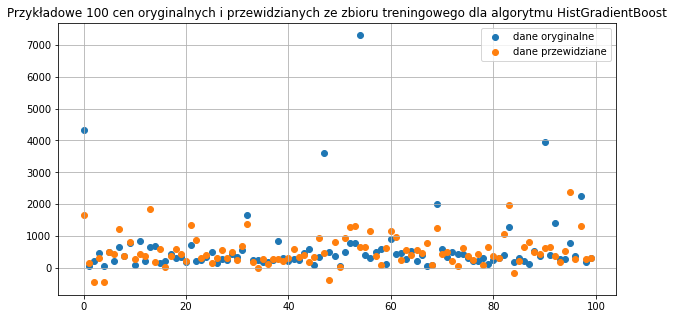

In [40]:
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size = 0.33, random_state = 123)

hist = HistGradientBoostingRegressor(max_iter=1500, max_leaf_nodes=31, max_depth=7)

hist.fit(train_x, train_y)

y_ = hist.predict(val_x)

y_pred = sc.inverse_transform([y_])
y_true = sc.inverse_transform([val_y])

score_ = hist.score(train_x, train_y)  
score_perc = mean_absolute_percentage_error(y_pred, y_true)
print("Training score", score_)
print("Mean absolute percentage error", score_perc)

x_ax = range(len(y_true[0][:100]))

plt.figure(figsize=(10,5))
plt.scatter(x_ax, y_true[0][:100], label="dane oryginalne")
plt.scatter(x_ax, y_pred[0][:100], label="dane przewidziane")
plt.title("Przykładowe 100 cen oryginalnych i przewidzianych ze zbioru treningowego dla algorytmu HistGradientBoost")
plt.grid()
plt.legend()
plt.show()

Training score:  0.35418988190551615
Training score:  0.4518482400552908
Training score:  0.5208108940412689
Training score:  0.56467927492471
Training score:  0.5975872341145432
Training score:  0.62485981572284
Training score:  0.6451147563822645
Training score:  0.6588656271687501
Training score:  0.6744589877781553
Training score:  0.6897499551470853
Training score:  0.6985339927113356
Training score:  0.7074053385327033
Training score:  0.714602934386659
Training score:  0.7222249422006586
Training score:  0.7292789074665663
Training score:  0.7354166053354441
Training score:  0.7432084236424215


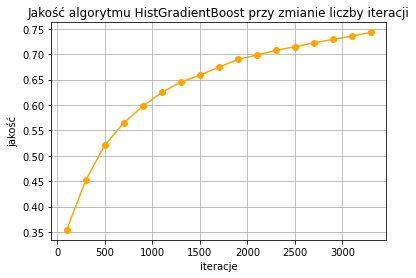

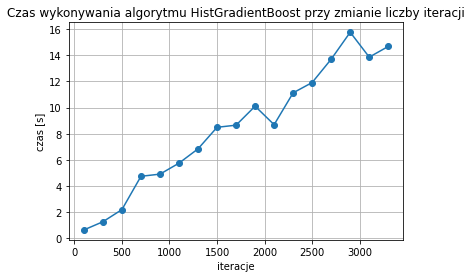

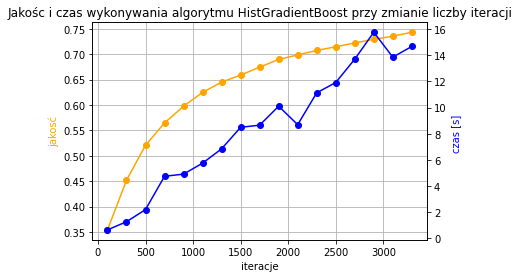

In [49]:
M = np.arange(100, 3500, 200)
skorr = []
times = []
for m in M:
    start = time.time()
    score_ = hist_model(X_train=X_train, y_train=y_train, X_test=X_test, m=m, n=31, d=7, l=0.1)
    stop = time.time()

    print("Training score: ", score_)
    skorr.append(score_)
    times.append(stop-start)

vizualization(
    x_lim = M,
    y_lim = skorr,
    y_time = times,
    title1 = 'Jakość algorytmu HistGradientBoost przy zmianie liczby iteracji',
    title2 = 'Czas wykonywania algorytmu HistGradientBoost przy zmianie liczby iteracji',
    title3 = 'Jakośc i czas wykonywania algorytmu HistGradientBoost przy zmianie liczby iteracji',
    x_label = 'iteracje'
)

Training score:  0.17816785332611662
Training score:  0.3422629543724317
Training score:  0.45577262183187806
Training score:  0.5263389149230429
Training score:  0.5546276784868935
Training score:  0.5926191783257775
Training score:  0.6121808790319894
Training score:  0.6230723983686814
Training score:  0.6419306532028786
Training score:  0.6531794087591617
Training score:  0.6595859212907409
Training score:  0.6679026169452742
Training score:  0.67945865336858
Training score:  0.6858899731262263
Training score:  0.6898394838709375


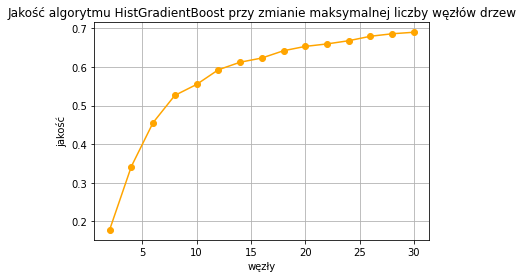

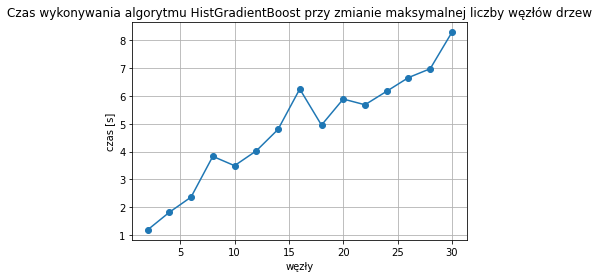

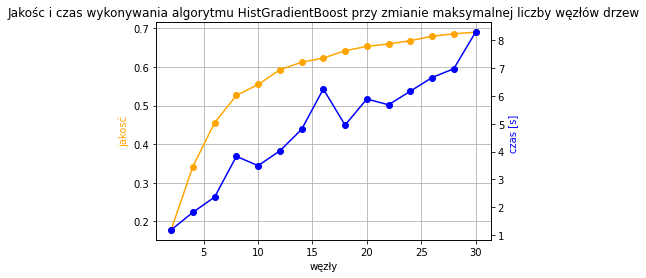

In [32]:
N = np.arange(2, 31, 2)
skorr = []
times = []
for n in N:
    start = time.time()
    score_ = hist_model(X_train=X_train, y_train=y_train, X_test=X_test, m=2000, n=n, d=7, l=0.1)
    stop = time.time()

    print("Training score: ", score_)
    skorr.append(score_)
    times.append(stop-start)

vizualization(
    x_lim = N,
    y_lim = skorr,
    y_time = times,
    title1 = 'Jakość algorytmu HistGradientBoost przy zmianie maksymalnej liczby węzłów drzew',
    title2 = 'Czas wykonywania algorytmu HistGradientBoost przy zmianie maksymalnej liczby węzłów drzew',
    title3 = 'Jakośc i czas wykonywania algorytmu HistGradientBoost przy zmianie maksymalnej liczby węzłów drzew',
    x_label = 'węzły'
)

Training score:  0.17816785332611662
Training score:  0.26081688925652124
Training score:  0.38433638156030236
Training score:  0.4953522022000899
Training score:  0.5823898168228283
Training score:  0.6259511078644537
Training score:  0.6531794087591617
Training score:  0.6650827256853715
Training score:  0.6717444896381137
Training score:  0.6815284378982939
Training score:  0.6805044797668701
Training score:  0.6864513529604839
Training score:  0.6816605633670427
Training score:  0.6816270667286202


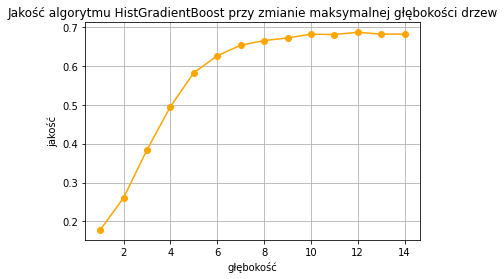

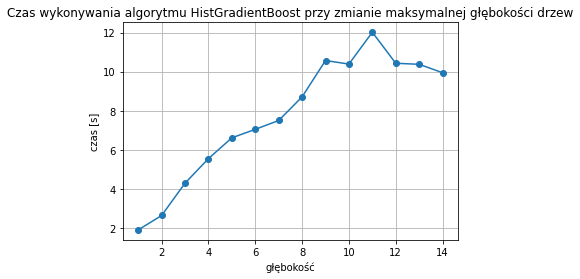

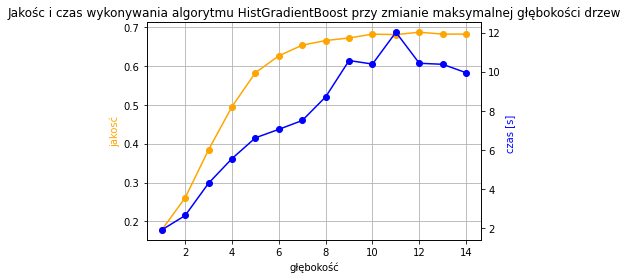

In [51]:
D = np.arange(1, 15, 1)
skorr = []
times = []
for d in D:
    start = time.time()
    score_ = hist_model(X_train=X_train, y_train=y_train, X_test=X_test, m=2000, n=20, d=d, l=0.1)
    stop = time.time()

    print("Training score: ", score_)
    skorr.append(score_)
    times.append(stop-start)

vizualization(
    x_lim = D,
    y_lim = skorr,
    y_time = times,
    title1 = 'Jakość algorytmu HistGradientBoost przy zmianie maksymalnej głębokości drzew',
    title2 = 'Czas wykonywania algorytmu HistGradientBoost przy zmianie maksymalnej głębokości drzew',
    title3 = 'Jakośc i czas wykonywania algorytmu HistGradientBoost przy zmianie maksymalnej głębokości drzew',
    x_label = 'głębokość'
)

Training score:  0.6650827256853715
Training score:  0.7432893051615711
Training score:  0.7843071317182011
Training score:  0.8044403943197919
Training score:  0.8190945049138824
Training score:  0.8273299304730339
Training score:  0.8329071615406481
Training score:  0.8372885363901005
Training score:  0.8407296328285501
Training score:  0.8432850275814843


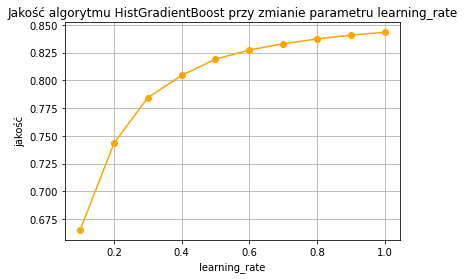

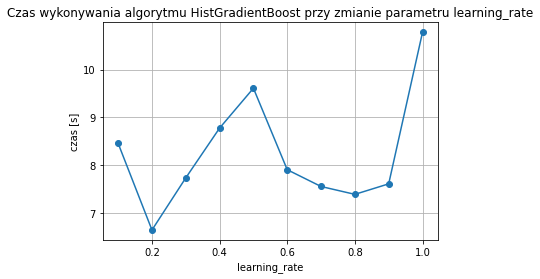

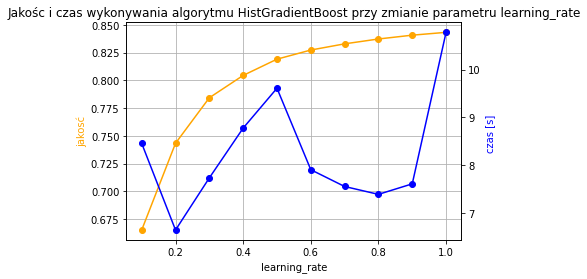

In [53]:
L = np.arange(0.1, 1.1, 0.1)
skorr = []
times = []
for l in L:
    start = time.time()
    score_ = hist_model(X_train=X_train, y_train=y_train, X_test=X_test, m=2000, n=20, d=8, l=l)
    stop = time.time()

    print("Training score: ", score_)
    skorr.append(score_)
    times.append(stop-start)

vizualization(
    x_lim = L,
    y_lim = skorr,
    y_time = times,
    title1 = 'Jakość algorytmu HistGradientBoost przy zmianie parametru learning_rate',
    title2 = 'Czas wykonywania algorytmu HistGradientBoost przy zmianie parametru learning_rate',
    title3 = 'Jakośc i czas wykonywania algorytmu HistGradientBoost przy zmianie parametru learning_rate',
    x_label = 'learning_rate'
)

In [35]:
start = time.time()
hist = HistGradientBoostingRegressor(max_iter=2000, max_leaf_nodes=20, max_depth=8, learning_rate=0.8)

hist.fit(X_train, y_train)

y_ = hist.predict(X_test)
stop = time.time()

y_pred = sc.inverse_transform([y_])

score_ = hist.score(X_train, y_train)  
print("Training score: ", score_)
print("Time:", stop-start)

solution = pd.DataFrame(y_pred[0], columns = ['Price'])
solution.to_excel('HistGradBoost_output_1.xlsx')

Training score:  0.8372885363901005
Time: 8.18071174621582


In [55]:
solution.describe()

,Price
count,1560.000000
mean,501.228315
std,537.025964
min,-1224.893128
25%,196.357448
50%,409.947269
75%,686.926575
max,4837.978053


## RandomForest

In [36]:
def forest_model(X_train, y_train, X_test, n, m):
    """"
    Returns score of fitted RandomForest model for varius parameters.

        Parameters:
                X_train (numpy.ndarray): Training set X
                y_train (numpy.ndarray): Training set y
                X_test (numpy.ndarray): Testing set to predict values for
                n (int): number of model estimators
                m (int): value of model depth
        Returns:
                score (float): training score of the model
    """
    rf = RandomForestRegressor(n_estimators=n, max_depth=m, random_state=50, n_jobs=-1)

    rf.fit(X_train, y_train)

    y_ = rf.predict(X_test)

    return rf.score(X_train, y_train)

Training score 0.7858265048346545
Mean absolute percentage error 0.5569078085926056


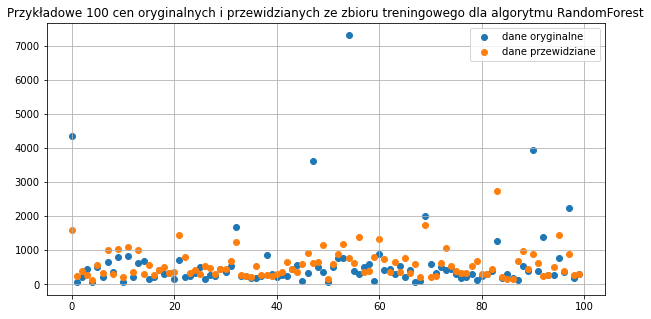

In [57]:
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size = 0.33, random_state = 123)

rf = RandomForestRegressor(n_estimators=60, max_depth=30, random_state=100, n_jobs=-1)

rf.fit(train_x, train_y)

y_ = rf.predict(val_x)

y_pred = sc.inverse_transform([y_])
y_true = sc.inverse_transform([val_y])

score_ = rf.score(train_x, train_y)  
score_perc = mean_absolute_percentage_error(y_pred, y_true)
print("Training score", score_)
print("Mean absolute percentage error", score_perc)

x_ax = range(len(y_true[0][:100]))

plt.figure(figsize=(10,5))
plt.scatter(x_ax, y_true[0][:100], label="dane oryginalne")
plt.scatter(x_ax, y_pred[0][:100], label="dane przewidziane")
plt.title("Przykładowe 100 cen oryginalnych i przewidzianych ze zbioru treningowego dla algorytmu RandomForest")
plt.grid()
plt.legend()
plt.show()

Training score:  0.35900247924672013
Training score:  0.7311849421159484
Training score:  0.7470179094959125
Training score:  0.7533126414381575
Training score:  0.7538402063744161
Training score:  0.7553298721256024
Training score:  0.7587735839800366
Training score:  0.7584149351366141
Training score:  0.7590945035106605
Training score:  0.7598812294354416
Training score:  0.7600191328029113
Training score:  0.7594195083153866
Training score:  0.758072891520489
Training score:  0.7585297218845232
Training score:  0.7600863418152355


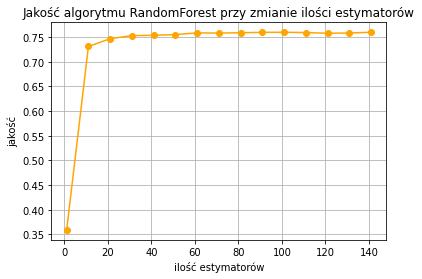

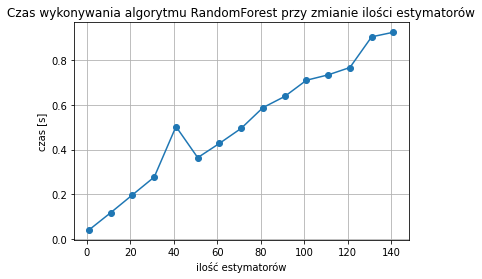

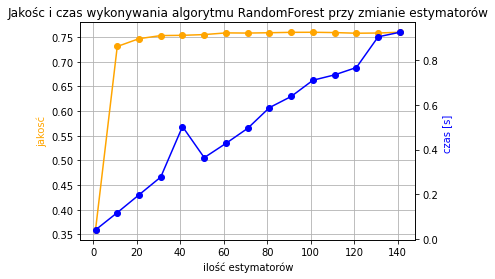

In [59]:
N = np.arange(1, 150, 10)
skorr = []
times = []
for n in N:
    start = time.time()
    score_ = forest_model(X_train=X_train, y_train=y_train, X_test=X_test, n=n, m=20)
    stop = time.time()

    print("Training score: ", score_)
    skorr.append(score_)
    times.append(stop-start)

vizualization(
    x_lim = N,
    y_lim = skorr,
    y_time = times,
    title1 = 'Jakość algorytmu RandomForest przy zmianie ilości estymatorów',
    title2 = 'Czas wykonywania algorytmu RandomForest przy zmianie ilości estymatorów',
    title3 = 'Jakośc i czas wykonywania algorytmu RandomForest przy zmianie estymatorów',
    x_label = 'ilość estymatorów'
)

Training score:  0.05688037166347948
Training score:  0.13950712303905188
Training score:  0.2822038531655312
Training score:  0.4043705792817258
Training score:  0.5215410792493558
Training score:  0.6201851385023865
Training score:  0.6892121383469001
Training score:  0.7293763071469259
Training score:  0.7491413883804573
Training score:  0.756617027861884
Training score:  0.7592452323398755
Training score:  0.7607819714329223
Training score:  0.7610263822156494
Training score:  0.7611401864908782
Training score:  0.7610844978030928
Training score:  0.7611497168509305


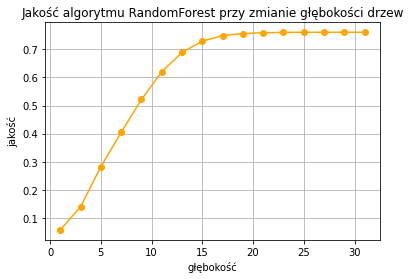

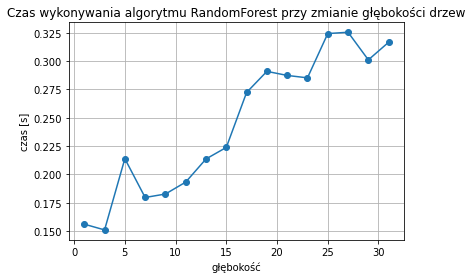

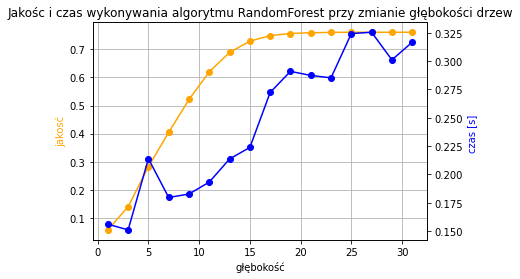

In [38]:
M = np.arange(1, 32, 2)
skorr = []
times = []
for m in M:
    start = time.time()
    score_ = forest_model(X_train=X_train, y_train=y_train, X_test=X_test, n=60, m=m)
    stop = time.time()

    print("Training score: ", score_)
    skorr.append(score_)
    times.append(stop-start)

vizualization(
    x_lim = M,
    y_lim = skorr,
    y_time = times,
    title1 = 'Jakość algorytmu RandomForest przy zmianie głębokości drzew',
    title2 = 'Czas wykonywania algorytmu RandomForest przy zmianie głębokości drzew',
    title3 = 'Jakośc i czas wykonywania algorytmu RandomForest przy zmianie głębokości drzew',
    x_label = 'głębokość'
)

In [39]:
start = time.time()
rf = RandomForestRegressor(n_estimators=60, max_depth=30, random_state=50, n_jobs=-1)
rf.fit(X_train, y_train)

y_ = rf.predict(X_test)
stop = time.time()
y_pred = sc.inverse_transform([y_])

score_ = rf.score(X_train, y_train)  
print("Training score: ", score_)
print("Time:", stop-start)

# return score_
solution = pd.DataFrame(y_pred[0], columns = ['Price'])
solution.to_excel('RandomForest_output_1.xlsx')

Training score:  0.76119561921585
Time: 0.2535548210144043


In [62]:
solution.describe()

,Price
count,1560.000000
mean,552.702686
std,384.491632
min,126.500000
25%,337.708958
50%,441.495500
75%,640.042750
max,3930.480667
